In [1]:
import pandas as pd   
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
df_chfusd = pd.read_csv('/content/CHF-USD Exchange Rate Clean.csv')
df_trends = pd.read_excel('/content/World_GT_Full.xlsx')

In [3]:
df_trends['Date'] = pd.to_datetime(df_trends.iloc[:, 0], infer_datetime_format=True)
df_chfusd['Date'] = pd.to_datetime(df_chfusd.iloc[:, 0], infer_datetime_format=True)

In [4]:
df_chfusd['CHF/USD Log Difference'] = np.log(df_chfusd['Adj Close']) - (np.log(df_chfusd['Adj Close']).shift(1))
df_chfusd['CHF/USD Log Difference']
df_chfusd = df_chfusd.dropna()

In [5]:
ts_df = df_chfusd.merge(df_trends, how = 'inner', on = ['Date'])

In [6]:
ts_df = ts_df.drop(['Log_Difference','Adj Close'], axis = 1)
ts_df = ts_df.set_index(ts_df.iloc[:,0])
ts_df = ts_df.drop(['Date'], axis = 1)
ts_df

,CHF/USD Log Difference,swiss franc,Europe,EUR,Switzerland,CHF,NASDAQ,S&P500,VIX,volatility,Germany,UK,sterling pound,GBP,Greece,Italy,Spain,France,DAX,unemployment,recession,euro,crisis,fed,finance,financial crisis,federal reserve,gold,inflation,treasuries,OPEC,contagion,corruption,disaster,futures,forwards,president,parliament,aid,EU,...,steel,silver,bronze,corn,commodities,natural gas,agriculture,emerging market,trade,interest rate,GDP,exports,imports,jobs,tax,tariff,uncertainty,gini,inequality,insurance,pension,liquidity,diversification,alpha,currency,CAPM,fixed income,commission,SEC,yield,real estate,eurodollar,regulations,deficit,yield curve,LIBOR,2008,bubble,energy,1939
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-01,-0.002987,0,42,3,6,3,12,27,2,0,9,78,0,0,19,6,25,38,1,4,0,6,18,9,27,0,12,17,13,0,0,0,64,6,9,32,3,4,13,3,...,20,49,54,23,8,8,21,0,43,4,26,8,79,9,16,0,0,11,0,44,59,0,16,45,42,0,0,8,30,6,58,0,37,7,0,15,0,46,37,18
2004-01-02,0.000242,0,58,12,8,2,22,0,19,31,10,76,0,1,15,5,23,32,3,6,0,5,12,16,47,0,12,18,32,0,8,0,6,5,12,8,3,1,23,3,...,18,36,20,10,26,27,27,0,38,18,21,33,90,11,21,34,15,0,0,68,46,0,8,51,48,0,0,13,27,41,68,0,33,15,0,23,0,30,43,28
2004-01-05,0.006472,0,39,0,4,0,14,0,30,0,7,23,0,0,14,6,17,15,0,7,0,3,26,10,41,0,0,27,20,0,0,0,0,15,3,0,5,0,10,2,...,15,42,39,5,14,30,56,0,40,37,100,14,28,16,21,23,0,14,59,50,19,0,0,55,66,0,0,21,68,30,82,0,34,51,0,0,0,23,52,15
2004-01-06,0.000081,0,73,5,6,2,35,0,10,30,12,100,0,0,23,6,24,40,2,10,0,6,20,18,87,0,27,19,64,0,3,0,41,8,19,0,5,8,20,5,...,29,37,43,21,25,19,42,12,60,19,31,36,41,14,23,59,10,5,17,100,67,15,11,57,74,22,39,26,70,31,54,15,80,47,74,75,0,29,84,45
2004-01-07,-0.006150,0,60,2,7,4,32,0,0,32,10,79,0,0,22,7,31,31,1,8,1,6,26,32,71,0,28,20,41,0,6,0,9,11,9,8,5,4,18,4,...,27,39,33,12,18,48,60,9,62,17,49,34,50,14,25,34,27,4,19,76,34,29,0,48,75,10,58,24,46,23,60,11,58,37,40,25,0,31,87,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-08,-0.004983,2,26,14,10,14,45,23,18,9,6,38,3,6,15,4,10,15,19,16,4,7,15,18,67,2,6,29,26,2,1,1,23,18,18,2,3,6,16,8,...,28,37,34,23,53,33,21,1,33,19,15,22,7,9,19,21,11,9,15,41,59,15,1,39,24,3,5,7,44,42,16,0,15,38,1,3,1,36,70,9
2021-09-09,-0.002596,1,23,14,8,13,45,31,16,9,6,38,2,6,13,4,9,12,22,13,4,7,16,20,63,4,6,27,22,2,2,1,25,18,18,3,3,5,17,8,...,25,36,37,22,40,29,23,2,34,18,15,25,9,9,18,21,7,8,16,39,52,12,1,38,24,8,4,7,44,41,15,1,15,55,2,2,1,37,66,8
2021-09-10,0.005799,1,20,13,7,12,41,27,10,7,5,37,1,5,11,4,9,11,18,11,3,7,14,19,57,2,6,27,22,2,2,1,19,17,15,2,3,5,15,8,...,23,36,37,23,47,25,20,3,36,16,15,23,7,8,16,18,8,7,14,36,48,11,1,36,22,5,4,6,41,37,14,0,11,45,0,2,1,39,60,7


In [7]:
ts_df.iloc[:,1:155] = ts_df.iloc[:,1:155].diff()

In [8]:
ts_df = ts_df.iloc[1:,:]

In [9]:
ts_df.head()

,CHF/USD Log Difference,swiss franc,Europe,EUR,Switzerland,CHF,NASDAQ,S&P500,VIX,volatility,Germany,UK,sterling pound,GBP,Greece,Italy,Spain,France,DAX,unemployment,recession,euro,crisis,fed,finance,financial crisis,federal reserve,gold,inflation,treasuries,OPEC,contagion,corruption,disaster,futures,forwards,president,parliament,aid,EU,...,steel,silver,bronze,corn,commodities,natural gas,agriculture,emerging market,trade,interest rate,GDP,exports,imports,jobs,tax,tariff,uncertainty,gini,inequality,insurance,pension,liquidity,diversification,alpha,currency,CAPM,fixed income,commission,SEC,yield,real estate,eurodollar,regulations,deficit,yield curve,LIBOR,2008,bubble,energy,1939
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-02,0.000242,0.0,16.0,9.0,2.0,-1.0,10.0,-27.0,17.0,31.0,1.0,-2.0,0.0,1.0,-4.0,-1.0,-2.0,-6.0,2.0,2.0,0.0,-1.0,-6.0,7.0,20.0,0.0,0.0,1.0,19.0,0.0,8.0,0.0,-58.0,-1.0,3.0,-24.0,0.0,-3.0,10.0,0.0,...,-2.0,-13.0,-34.0,-13.0,18.0,19.0,6.0,0.0,-5.0,14.0,-5.0,25.0,11.0,2.0,5.0,34.0,15.0,-11.0,0.0,24.0,-13.0,0.0,-8.0,6.0,6.0,0.0,0.0,5.0,-3.0,35.0,10.0,0.0,-4.0,8.0,0.0,8.0,0.0,-16.0,6.0,10.0
2004-01-05,0.006472,0.0,-19.0,-12.0,-4.0,-2.0,-8.0,0.0,11.0,-31.0,-3.0,-53.0,0.0,-1.0,-1.0,1.0,-6.0,-17.0,-3.0,1.0,0.0,-2.0,14.0,-6.0,-6.0,0.0,-12.0,9.0,-12.0,0.0,-8.0,0.0,-6.0,10.0,-9.0,-8.0,2.0,-1.0,-13.0,-1.0,...,-3.0,6.0,19.0,-5.0,-12.0,3.0,29.0,0.0,2.0,19.0,79.0,-19.0,-62.0,5.0,0.0,-11.0,-15.0,14.0,59.0,-18.0,-27.0,0.0,-8.0,4.0,18.0,0.0,0.0,8.0,41.0,-11.0,14.0,0.0,1.0,36.0,0.0,-23.0,0.0,-7.0,9.0,-13.0
2004-01-06,0.000081,0.0,34.0,5.0,2.0,2.0,21.0,0.0,-20.0,30.0,5.0,77.0,0.0,0.0,9.0,0.0,7.0,25.0,2.0,3.0,0.0,3.0,-6.0,8.0,46.0,0.0,27.0,-8.0,44.0,0.0,3.0,0.0,41.0,-7.0,16.0,0.0,0.0,8.0,10.0,3.0,...,14.0,-5.0,4.0,16.0,11.0,-11.0,-14.0,12.0,20.0,-18.0,-69.0,22.0,13.0,-2.0,2.0,36.0,10.0,-9.0,-42.0,50.0,48.0,15.0,11.0,2.0,8.0,22.0,39.0,5.0,2.0,1.0,-28.0,15.0,46.0,-4.0,74.0,75.0,0.0,6.0,32.0,30.0
2004-01-07,-0.006150,0.0,-13.0,-3.0,1.0,2.0,-3.0,0.0,-10.0,2.0,-2.0,-21.0,0.0,0.0,-1.0,1.0,7.0,-9.0,-1.0,-2.0,1.0,0.0,6.0,14.0,-16.0,0.0,1.0,1.0,-23.0,0.0,3.0,0.0,-32.0,3.0,-10.0,8.0,0.0,-4.0,-2.0,-1.0,...,-2.0,2.0,-10.0,-9.0,-7.0,29.0,18.0,-3.0,2.0,-2.0,18.0,-2.0,9.0,0.0,2.0,-25.0,17.0,-1.0,2.0,-24.0,-33.0,14.0,-11.0,-9.0,1.0,-12.0,19.0,-2.0,-24.0,-8.0,6.0,-4.0,-22.0,-10.0,-34.0,-50.0,0.0,2.0,3.0,-25.0
2004-01-08,0.010462,0.0,7.0,5.0,1.0,-2.0,16.0,0.0,6.0,-21.0,-1.0,3.0,8.0,0.0,-5.0,0.0,3.0,4.0,3.0,-3.0,0.0,-1.0,-7.0,-8.0,-8.0,2.0,-5.0,-2.0,0.0,0.0,-2.0,0.0,-5.0,0.0,12.0,15.0,0.0,2.0,3.0,1.0,...,2.0,-4.0,5.0,3.0,5.0,-8.0,-11.0,-9.0,8.0,6.0,-8.0,9.0,18.0,-2.0,-3.0,16.0,3.0,2.0,25.0,5.0,18.0,-11.0,0.0,-5.0,-1.0,-10.0,-20.0,-3.0,-13.0,5.0,-5.0,-11.0,21.0,18.0,-40.0,26.0,0.0,-1.0,-7.0,-3.0


In [10]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(ts_df.copy())

In [11]:
window_size = 2
data['CHF/USD_RealVol'] = data['CHF/USD Log Difference'].rolling(window_size).std()*(252**0.5)

In [12]:
data['CHF/USD_RealVol'].quantile(0.75) #75th Percentile

0.10117049524963027

In [13]:
# Adding the lag of the target variable from 6 steps back up to 24

for column in data:

  for i in range(1, 14):
      data[f"{column}_lag_{i}"] = data[column].shift(i)

In [14]:
data['HighVolMoment_CHF/USD'] = [1 if i > 0.10 else 0 for i in data['CHF/USD_RealVol']]

In [15]:
data

,CHF/USD Log Difference,swiss franc,Europe,EUR,Switzerland,CHF,NASDAQ,S&P500,VIX,volatility,Germany,UK,sterling pound,GBP,Greece,Italy,Spain,France,DAX,unemployment,recession,euro,crisis,fed,finance,financial crisis,federal reserve,gold,inflation,treasuries,OPEC,contagion,corruption,disaster,futures,forwards,president,parliament,aid,EU,...,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,energy_lag_8,energy_lag_9,energy_lag_10,energy_lag_11,energy_lag_12,energy_lag_13,1939_lag_1,1939_lag_2,1939_lag_3,1939_lag_4,1939_lag_5,1939_lag_6,1939_lag_7,1939_lag_8,1939_lag_9,1939_lag_10,1939_lag_11,1939_lag_12,1939_lag_13,CHF/USD_RealVol_lag_1,CHF/USD_RealVol_lag_2,CHF/USD_RealVol_lag_3,CHF/USD_RealVol_lag_4,CHF/USD_RealVol_lag_5,CHF/USD_RealVol_lag_6,CHF/USD_RealVol_lag_7,CHF/USD_RealVol_lag_8,CHF/USD_RealVol_lag_9,CHF/USD_RealVol_lag_10,CHF/USD_RealVol_lag_11,CHF/USD_RealVol_lag_12,CHF/USD_RealVol_lag_13,HighVolMoment_CHF/USD
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-02,0.000242,0.0,16.0,9.0,2.0,-1.0,10.0,-27.0,17.0,31.0,1.0,-2.0,0.0,1.0,-4.0,-1.0,-2.0,-6.0,2.0,2.0,0.0,-1.0,-6.0,7.0,20.0,0.0,0.0,1.0,19.0,0.0,8.0,0.0,-58.0,-1.0,3.0,-24.0,0.0,-3.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2004-01-05,0.006472,0.0,-19.0,-12.0,-4.0,-2.0,-8.0,0.0,11.0,-31.0,-3.0,-53.0,0.0,-1.0,-1.0,1.0,-6.0,-17.0,-3.0,1.0,0.0,-2.0,14.0,-6.0,-6.0,0.0,-12.0,9.0,-12.0,0.0,-8.0,0.0,-6.0,10.0,-9.0,-8.0,2.0,-1.0,-13.0,-1.0,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2004-01-06,0.000081,0.0,34.0,5.0,2.0,2.0,21.0,0.0,-20.0,30.0,5.0,77.0,0.0,0.0,9.0,0.0,7.0,25.0,2.0,3.0,0.0,3.0,-6.0,8.0,46.0,0.0,27.0,-8.0,44.0,0.0,3.0,0.0,41.0,-7.0,16.0,0.0,0.0,8.0,10.0,3.0,...,9.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-13.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2004-01-07,-0.006150,0.0,-13.0,-3.0,1.0,2.0,-3.0,0.0,-10.0,2.0,-2.0,-21.0,0.0,0.0,-1.0,1.0,7.0,-9.0,-1.0,-2.0,1.0,0.0,6.0,14.0,-16.0,0.0,1.0,1.0,-23.0,0.0,3.0,0.0,-32.0,3.0,-10.0,8.0,0.0,-4.0,-2.0,-1.0,...,32.0,9.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,-13.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071731,0.069930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2004-01-08,0.010462,0.0,7.0,5.0,1.0,-2.0,16.0,0.0,6.0,-21.0,-1.0,3.0,8.0,0.0,-5.0,0.0,3.0,4.0,3.0,-3.0,0.0,-1.0,-7.0,-8.0,-8.0,2.0,-5.0,-2.0,0.0,0.0,-2.0,0.0,-5.0,0.0,12.0,15.0,0.0,2.0,3.0,1.0,...,3.0,32.0,9.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-25.0,30.0,-13.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069947,0.071731,0.069930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-08,-0.004983,0.0,1.0,-1.0,2.0,1.0,5.0,-7.0,4.0,0.0,1.0,2.0,2.0,1.0,1.0,0.0,2.0,-3.0,1.0,-4.0,1.0,0.0,-1.0,-1.0,-2.0,0.0,1.0,1.0,1.0,0.0,-1.0,0.0,-5.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,0.0,...,14.0,-10.0,-1.0,-1.0,2.0,4.0,1.0,-1.0,-4.0,-2.0,5.0,3.0,-2.0,0.0,1.0,-1.0,-5.0,6.0,2.0,-2.0,1.0,-1.0,-1.0,1.0,1.0,-2.0,0.020731,0.004629,0.015264,0.025689,0.096450,0.156145,0.135427,0.046071,0.003212,0.068997,0.037140,0.038636,0.017805,0
2021-09-09,-0.002596,-1.0,-3.0,0.0,-2.0,-1.0,0.0,8.0,-2.0,0.0,0.0,0.0,-1.0,0.0,-2.0,0.0,-1.0,-3.0,3.0,-3.0,0.0,0.0,1.0,2.0,-4.0,2.0,0.0,-2.0,-4.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,-1.0,1.0,0.0,...,4.0,14.0,-10.0,-1.0,-1.0,2.0,4.0,1.0,-1.0,-4.0,-2.0,5.0,3.0,1.0,0.0,1.0,-1.0,-5.0,6.0,2.0,-2.0,1.0,-1.0,-1.0,1.0,1.0,0.043176,0.020

In [16]:
data = data.iloc[14:,:]

In [17]:
fin_data = [data.iloc[:,0:1], data.iloc[:,156:]]
final_data = pd.concat(fin_data, axis=1)

In [18]:
final_data

,CHF/USD Log Difference,CHF/USD Log Difference_lag_1,CHF/USD Log Difference_lag_2,CHF/USD Log Difference_lag_3,CHF/USD Log Difference_lag_4,CHF/USD Log Difference_lag_5,CHF/USD Log Difference_lag_6,CHF/USD Log Difference_lag_7,CHF/USD Log Difference_lag_8,CHF/USD Log Difference_lag_9,CHF/USD Log Difference_lag_10,CHF/USD Log Difference_lag_11,CHF/USD Log Difference_lag_12,CHF/USD Log Difference_lag_13,swiss franc_lag_1,swiss franc_lag_2,swiss franc_lag_3,swiss franc_lag_4,swiss franc_lag_5,swiss franc_lag_6,swiss franc_lag_7,swiss franc_lag_8,swiss franc_lag_9,swiss franc_lag_10,swiss franc_lag_11,swiss franc_lag_12,swiss franc_lag_13,Europe_lag_1,Europe_lag_2,Europe_lag_3,Europe_lag_4,Europe_lag_5,Europe_lag_6,Europe_lag_7,Europe_lag_8,Europe_lag_9,Europe_lag_10,Europe_lag_11,Europe_lag_12,Europe_lag_13,...,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,energy_lag_8,energy_lag_9,energy_lag_10,energy_lag_11,energy_lag_12,energy_lag_13,1939_lag_1,1939_lag_2,1939_lag_3,1939_lag_4,1939_lag_5,1939_lag_6,1939_lag_7,1939_lag_8,1939_lag_9,1939_lag_10,1939_lag_11,1939_lag_12,1939_lag_13,CHF/USD_RealVol_lag_1,CHF/USD_RealVol_lag_2,CHF/USD_RealVol_lag_3,CHF/USD_RealVol_lag_4,CHF/USD_RealVol_lag_5,CHF/USD_RealVol_lag_6,CHF/USD_RealVol_lag_7,CHF/USD_RealVol_lag_8,CHF/USD_RealVol_lag_9,CHF/USD_RealVol_lag_10,CHF/USD_RealVol_lag_11,CHF/USD_RealVol_lag_12,CHF/USD_RealVol_lag_13,HighVolMoment_CHF/USD
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-22,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.006472,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,-13.0,34.0,-19.0,...,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,32.0,9.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,30.0,-13.0,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,0.069930,0
2004-01-23,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,-13.0,34.0,...,-14.0,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,32.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,30.0,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,1
2004-01-26,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,-13.0,...,-4.0,-14.0,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,0.137136,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0
2004-01-27,0.012024,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-14.0,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,9.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,...,3.0,-4.0,-14.0,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,-11.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,0.036069,0.137136,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,1
2004-01-28,-0.014332,0.012024,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,12.0,-14.0,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,9.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,...,16.0,3.0,-4.0,-14.0,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-4.0,-11.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-

#Classification

In [19]:
# Creating a copy of the initial datagrame to make various transformations 
classification_df = pd.DataFrame(final_data.copy())

In [20]:
len(classification_df)

4604

In [21]:
classification_df

,CHF/USD Log Difference,CHF/USD Log Difference_lag_1,CHF/USD Log Difference_lag_2,CHF/USD Log Difference_lag_3,CHF/USD Log Difference_lag_4,CHF/USD Log Difference_lag_5,CHF/USD Log Difference_lag_6,CHF/USD Log Difference_lag_7,CHF/USD Log Difference_lag_8,CHF/USD Log Difference_lag_9,CHF/USD Log Difference_lag_10,CHF/USD Log Difference_lag_11,CHF/USD Log Difference_lag_12,CHF/USD Log Difference_lag_13,swiss franc_lag_1,swiss franc_lag_2,swiss franc_lag_3,swiss franc_lag_4,swiss franc_lag_5,swiss franc_lag_6,swiss franc_lag_7,swiss franc_lag_8,swiss franc_lag_9,swiss franc_lag_10,swiss franc_lag_11,swiss franc_lag_12,swiss franc_lag_13,Europe_lag_1,Europe_lag_2,Europe_lag_3,Europe_lag_4,Europe_lag_5,Europe_lag_6,Europe_lag_7,Europe_lag_8,Europe_lag_9,Europe_lag_10,Europe_lag_11,Europe_lag_12,Europe_lag_13,...,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,energy_lag_8,energy_lag_9,energy_lag_10,energy_lag_11,energy_lag_12,energy_lag_13,1939_lag_1,1939_lag_2,1939_lag_3,1939_lag_4,1939_lag_5,1939_lag_6,1939_lag_7,1939_lag_8,1939_lag_9,1939_lag_10,1939_lag_11,1939_lag_12,1939_lag_13,CHF/USD_RealVol_lag_1,CHF/USD_RealVol_lag_2,CHF/USD_RealVol_lag_3,CHF/USD_RealVol_lag_4,CHF/USD_RealVol_lag_5,CHF/USD_RealVol_lag_6,CHF/USD_RealVol_lag_7,CHF/USD_RealVol_lag_8,CHF/USD_RealVol_lag_9,CHF/USD_RealVol_lag_10,CHF/USD_RealVol_lag_11,CHF/USD_RealVol_lag_12,CHF/USD_RealVol_lag_13,HighVolMoment_CHF/USD
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-22,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.006472,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,-13.0,34.0,-19.0,...,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,32.0,9.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,30.0,-13.0,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,0.069930,0
2004-01-23,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,-13.0,34.0,...,-14.0,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,32.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,30.0,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,1
2004-01-26,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,-13.0,...,-4.0,-14.0,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,0.137136,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0
2004-01-27,0.012024,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-14.0,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,9.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,...,3.0,-4.0,-14.0,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,-11.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,0.036069,0.137136,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,1
2004-01-28,-0.014332,0.012024,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,12.0,-14.0,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,9.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,...,16.0,3.0,-4.0,-14.0,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-4.0,-11.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-

In [22]:
classification_df['ExtendedHighVolMoment_CHF/USD'] = 0

#classification_df['HighVolMoment_CHF/USD'].iloc[100:102].sum()

#classification_df['HighVolMoment_CHF/USD'].iloc[100]

In [23]:
#Definining Extended High Vol Moment (2 Days):

for i in range(1, len(classification_df), 1):

  if classification_df['HighVolMoment_CHF/USD'].iloc[i] == 0:

    classification_df['ExtendedHighVolMoment_CHF/USD'].iloc[i] = 0

  else:
    
    if (classification_df['HighVolMoment_CHF/USD'].iloc[i] == 1 and classification_df['HighVolMoment_CHF/USD'].iloc[i-1] == 1) or (classification_df['HighVolMoment_CHF/USD'].iloc[i] == 1 and classification_df['HighVolMoment_CHF/USD'].iloc[i+1] == 1):

        classification_df['ExtendedHighVolMoment_CHF/USD'].iloc[i] = 1
      
    else:

        classification_df['ExtendedHighVolMoment_CHF/USD'].iloc[i] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



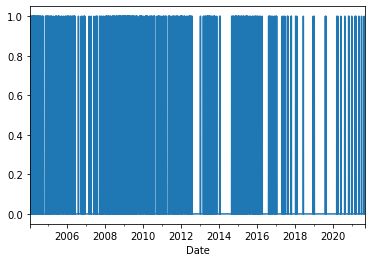

In [24]:
classification_df['ExtendedHighVolMoment_CHF/USD'].plot()

In [25]:
classification_df.tail(50)

,CHF/USD Log Difference,CHF/USD Log Difference_lag_1,CHF/USD Log Difference_lag_2,CHF/USD Log Difference_lag_3,CHF/USD Log Difference_lag_4,CHF/USD Log Difference_lag_5,CHF/USD Log Difference_lag_6,CHF/USD Log Difference_lag_7,CHF/USD Log Difference_lag_8,CHF/USD Log Difference_lag_9,CHF/USD Log Difference_lag_10,CHF/USD Log Difference_lag_11,CHF/USD Log Difference_lag_12,CHF/USD Log Difference_lag_13,swiss franc_lag_1,swiss franc_lag_2,swiss franc_lag_3,swiss franc_lag_4,swiss franc_lag_5,swiss franc_lag_6,swiss franc_lag_7,swiss franc_lag_8,swiss franc_lag_9,swiss franc_lag_10,swiss franc_lag_11,swiss franc_lag_12,swiss franc_lag_13,Europe_lag_1,Europe_lag_2,Europe_lag_3,Europe_lag_4,Europe_lag_5,Europe_lag_6,Europe_lag_7,Europe_lag_8,Europe_lag_9,Europe_lag_10,Europe_lag_11,Europe_lag_12,Europe_lag_13,...,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,energy_lag_8,energy_lag_9,energy_lag_10,energy_lag_11,energy_lag_12,energy_lag_13,1939_lag_1,1939_lag_2,1939_lag_3,1939_lag_4,1939_lag_5,1939_lag_6,1939_lag_7,1939_lag_8,1939_lag_9,1939_lag_10,1939_lag_11,1939_lag_12,1939_lag_13,CHF/USD_RealVol_lag_1,CHF/USD_RealVol_lag_2,CHF/USD_RealVol_lag_3,CHF/USD_RealVol_lag_4,CHF/USD_RealVol_lag_5,CHF/USD_RealVol_lag_6,CHF/USD_RealVol_lag_7,CHF/USD_RealVol_lag_8,CHF/USD_RealVol_lag_9,CHF/USD_RealVol_lag_10,CHF/USD_RealVol_lag_11,CHF/USD_RealVol_lag_12,CHF/USD_RealVol_lag_13,HighVolMoment_CHF/USD,ExtendedHighVolMoment_CHF/USD
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-07,-0.002783,-0.000542,0.004655,-0.001027,-0.004388,-0.001402,-0.003180,0.001570,-0.000022,0.000523,0.000065,0.004171,-0.005260,-0.009988,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-2.0,1.0,-1.0,1.0,-3.0,4.0,-2.0,-2.0,0.0,5.0,-2.0,-4.0,2.0,-1.0,2.0,-1.0,...,-2.0,-4.0,-1.0,3.0,1.0,-1.0,-2.0,1.0,-1.0,-1.0,3.0,-1.0,1.0,1.0,-2.0,1.0,1.0,-2.0,-1.0,0.0,1.0,-2.0,2.0,-4.0,3.0,0.058334,0.063780,0.037720,0.033518,0.019968,0.053320,0.017867,0.006113,0.005133,0.046088,0.105864,0.053073,0.012495,0,0
2021-07-08,-0.000789,-0.002783,-0.000542,0.004655,-0.001027,-0.004388,-0.001402,-0.003180,0.001570,-0.000022,0.000523,0.000065,0.004171,-0.005260,1.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-2.0,1.0,1.0,1.0,-3.0,4.0,-2.0,-2.0,0.0,5.0,-2.0,-4.0,2.0,-1.0,2.0,...,4.0,-2.0,-4.0,-1.0,3.0,1.0,-1.0,-2.0,1.0,-1.0,-1.0,3.0,-2.0,1.0,1.0,-2.0,1.0,1.0,-2.0,-1.0,0.0,1.0,-2.0,2.0,-4.0,0.025156,0.058334,0.063780,0.037720,0.033518,0.019968,0.053320,0.017867,0.006113,0.005133,0.046088,0.105864,0.053073,0,0
2021-07-09,0.011586,-0.000789,-0.002783,-0.000542,0.004655,-0.001027,-0.004388,-0.001402,-0.003180,0.001570,-0.000022,0.000523,0.000065,0.004171,0.0,1.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-2.0,-3.0,1.0,1.0,-3.0,4.0,-2.0,-2.0,0.0,5.0,-2.0,-4.0,2.0,-1.0,...,1.0,4.0,-2.0,-4.0,-1.0,3.0,1.0,-1.0,-2.0,1.0,-1.0,-1.0,4.0,-2.0,1.0,1.0,-2.0,1.0,1.0,-2.0,-1.0,0.0,1.0,-2.0,2.0,0.022383,0.025156,0.058334,0.063780,0.037720,0.033518,0.019968,0.053320,0.017867,0.006113,0.005133,0.046088,0.105864,1,1
2021-07-12,0.000765,0.011586,-0.000789,-0.002783,-0.000542,0.004655,-0.001027,-0.004388,-0.001402,-0.003180,0.001570,-0.000022,0.000523,0.000065,0.0,0.0,1.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,-3.0,1.0,1.0,-3.0,4.0,-2.0,-2.0,0.0,5.0,-2.0,-4.0,2.0,...,2.0,1.0,4.0,-2.0,-4.0,-1.0,3.0,1.0,-1.0,-2.0,1.0,-1.0,-3.0,4.0,-2.0,1.0,1.0,-2.0,1.0,1.0,-2.0,-1.0,0.0,1.0,-2.0,0.138912,0.022383,0.025156,0.058334,0.063780,0.037720,0.033518,0.019968,0.053320,0.017867,0.006113,0.005133,0.046088,1,1
2021-07-13,-0.001072,0.000765,0.011586,-0.000789,-0.002783,-0.000542,0.004655,-0.001027,-0.004388,-0.001402,-0.003180,0.001570,-0.000022,0.000523,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,-1.0,-3.0,1.0,1.0,-3.0,4.0,-2.0,-2.0,0.0,5.0,-2.0,-4.0,...,-7.0,2.0,1.0,4.0,-2.0,-4.0,-1.0,3.0,1.0,-1.0,-2.0,1.0,1.0,-3.0,4.0,-2.0,1.0,1.0,-2.0,1.0,1.0,-2.0,-1.0,0.0,1.0,0.121464,0.138912,0.022383,0.025156,0.058334,0.063780,0.037720,0.033518,0.019968,0.053320

In [26]:
#window_size = 2
#classification_df['CHF/USD_RealVol'] = classification_df['CHF/USD Log Difference'].rolling(window_size).std()*(252**0.5)

In [27]:
#classification_df['CHF/USD_RealVol'].quantile(0.75) #75th Percentile

In [28]:
#classification_df['HighVolMoment_CHF/USD'] = [1 if i > 0.125 else 0 for i in classification_df['CHF/USD_RealVol']]

In [29]:
classification_df

,CHF/USD Log Difference,CHF/USD Log Difference_lag_1,CHF/USD Log Difference_lag_2,CHF/USD Log Difference_lag_3,CHF/USD Log Difference_lag_4,CHF/USD Log Difference_lag_5,CHF/USD Log Difference_lag_6,CHF/USD Log Difference_lag_7,CHF/USD Log Difference_lag_8,CHF/USD Log Difference_lag_9,CHF/USD Log Difference_lag_10,CHF/USD Log Difference_lag_11,CHF/USD Log Difference_lag_12,CHF/USD Log Difference_lag_13,swiss franc_lag_1,swiss franc_lag_2,swiss franc_lag_3,swiss franc_lag_4,swiss franc_lag_5,swiss franc_lag_6,swiss franc_lag_7,swiss franc_lag_8,swiss franc_lag_9,swiss franc_lag_10,swiss franc_lag_11,swiss franc_lag_12,swiss franc_lag_13,Europe_lag_1,Europe_lag_2,Europe_lag_3,Europe_lag_4,Europe_lag_5,Europe_lag_6,Europe_lag_7,Europe_lag_8,Europe_lag_9,Europe_lag_10,Europe_lag_11,Europe_lag_12,Europe_lag_13,...,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,energy_lag_8,energy_lag_9,energy_lag_10,energy_lag_11,energy_lag_12,energy_lag_13,1939_lag_1,1939_lag_2,1939_lag_3,1939_lag_4,1939_lag_5,1939_lag_6,1939_lag_7,1939_lag_8,1939_lag_9,1939_lag_10,1939_lag_11,1939_lag_12,1939_lag_13,CHF/USD_RealVol_lag_1,CHF/USD_RealVol_lag_2,CHF/USD_RealVol_lag_3,CHF/USD_RealVol_lag_4,CHF/USD_RealVol_lag_5,CHF/USD_RealVol_lag_6,CHF/USD_RealVol_lag_7,CHF/USD_RealVol_lag_8,CHF/USD_RealVol_lag_9,CHF/USD_RealVol_lag_10,CHF/USD_RealVol_lag_11,CHF/USD_RealVol_lag_12,CHF/USD_RealVol_lag_13,HighVolMoment_CHF/USD,ExtendedHighVolMoment_CHF/USD
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-22,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.006472,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,-13.0,34.0,-19.0,...,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,32.0,9.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,30.0,-13.0,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,0.069930,0,0
2004-01-23,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,-13.0,34.0,...,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,32.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,30.0,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,1,0
2004-01-26,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,-13.0,...,-14.0,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,0.137136,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0,0
2004-01-27,0.012024,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-14.0,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,9.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,...,-4.0,-14.0,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,-11.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,0.036069,0.137136,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,1,1
2004-01-28,-0.014332,0.012024,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,12.0,-14.0,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,9.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,...,3.0,-4.0,-14.0,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-4.0,-11.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-

In [30]:
y = classification_df['ExtendedHighVolMoment_CHF/USD']
X = classification_df.drop(['CHF/USD Log Difference', 'HighVolMoment_CHF/USD', 'ExtendedHighVolMoment_CHF/USD'], axis=1)

#Test Visualization

In [31]:
#fig12 = go.Figure([go.Scatter(name = 'High Volatility Moment', x=y_test.index, y=y_test, opacity=1)])

#fig11.update_layout(
#    paper_bgcolor='rgba(0,0,0,0)',
#    plot_bgcolor = 'rgba(0,0,0,0)'
#)

#fig12.add_trace(go.Scatter(
#    name="CHF/USD Realized Volatility", x=X_test.index, y=X_test['CHF/USD_RealVol_lag_1'].shift(-1), opacity=1
#))

#fig11.update_xaxes(showline=True, linewidth=1, linecolor='black')
#fig11.update_yaxes(showline=True, linewidth=1, linecolor='black')

#fig11.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='LightGrey')
#fig11.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='LightGrey')

#fig12.update_layout(
#    xaxis_title="Date",
#    yaxis_title="",
#    width=2200,
#    height=1100,
#    font=dict(
#        size=30
#    )
#)

#fig12.update_layout(legend=dict(
#    yanchor="top",
#    y=0.95,
#    xanchor="left",
#    x=0.75
#))

#fig12.show()

#Train-Test Split 

In [32]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [33]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [34]:
# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

#Testing Models

##Benchmark

##Model 1: Logistic Regression


In [35]:
from sklearn.linear_model import LogisticRegression
LR1 = LogisticRegression(random_state=42, max_iter=10000).fit(X_train, y_train)

In [36]:
prob_predictions1 = LR1.predict_proba(X_test)
pred1 = prob_predictions1[:,1]

In [37]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="LR Predicted",
    mode="markers+lines", x=X_test.index, y=pred1
))

fig1.show()

In [38]:
prediction1 = LR1.predict(X_test)

In [39]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction1)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction1)}")
print(f"Precision Score: {precision_score(y_test, prediction1)}")
print(f"F1 Score: {f1_score(y_test, prediction1)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred1, squared=False)}")

Recall Score: 0.3333333333333333
Accuracy Score: 0.7076700434153401
Precision Score: 0.07161803713527852
F1 Score: 0.11790393013100438
RMSE of Probability Score: 0.5238871035753108


##Model 2: SGD Classifier

In [40]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
SGD2 = CalibratedClassifierCV(SGDClassifier(random_state=42, max_iter=10000)).fit(X_train, y_train)

In [41]:
prob_predictions2 = SGD2.predict_proba(X_test)
pred2 = prob_predictions2[:,1]

In [42]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="SGD2 Predicted",
    mode="markers+lines", x=X_test.index, y=pred2
))

fig1.show()

In [43]:
prediction2 = SGD2.predict(X_test)

In [44]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction2)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction2)}")
print(f"Precision Score: {precision_score(y_test, prediction2)}")
print(f"F1 Score: {f1_score(y_test, prediction2)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred2, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9413892908827786
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.29107390914570824


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



##Model 3: Passive Aggressive Classifier 

In [45]:
from sklearn.linear_model import PassiveAggressiveClassifier
PAC3 = CalibratedClassifierCV(PassiveAggressiveClassifier(max_iter=10000, random_state=42)).fit(X_train, y_train)

In [46]:
prob_predictions3 = PAC3.predict_proba(X_test)
pred3 = prob_predictions3[:,1]

In [47]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="PAC3 Predicted",
    mode="markers+lines", x=X_test.index, y=pred3
))

fig1.show()

In [48]:
prediction3 = PAC3.predict(X_test)

In [49]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction3)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction3)}")
print(f"Precision Score: {precision_score(y_test, prediction3)}")
print(f"F1 Score: {f1_score(y_test, prediction3)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred3, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9413892908827786
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.2921952583492953


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



##Model 4: Perceptron

In [50]:
from sklearn.linear_model import Perceptron
Per4 = CalibratedClassifierCV(Perceptron(tol=1e-3, random_state=42)).fit(X_train, y_train)

In [51]:
prob_predictions4 = Per4.predict_proba(X_test)
pred4 = prob_predictions4[:,1]

In [52]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="Per4 Predicted",
    mode="markers+lines", x=X_test.index, y=pred4
))

fig1.show()

In [53]:
prediction4 = Per4.predict(X_test)

In [54]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction4)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction4)}")
print(f"Precision Score: {precision_score(y_test, prediction4)}")
print(f"F1 Score: {f1_score(y_test, prediction4)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred4, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9413892908827786
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.29107390914570824


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



##Model 5: SVC

In [55]:
from sklearn.svm import SVC
SVC5 = SVC(probability=True).fit(X_train, y_train)

In [56]:
prob_predictions5 = SVC5.predict_proba(X_test)
pred5 = prob_predictions5[:,1]

In [57]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="SVC5 Predicted",
    mode="markers+lines", x=X_test.index, y=pred5
))

fig1.show()

In [58]:
prediction5 = SVC5.predict(X_test)

In [59]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction5)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction5)}")
print(f"Precision Score: {precision_score(y_test, prediction5)}")
print(f"F1 Score: {f1_score(y_test, prediction5)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred5, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9413892908827786
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.28682899591964856


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



##Model 6: NuSVC

In [60]:
from sklearn.svm import NuSVC
NuSVC6 = NuSVC(probability=True, nu=0.01).fit(X_train, y_train)

In [61]:
prob_predictions6 = NuSVC6.predict_proba(X_test)
pred6 = prob_predictions6[:,1]

In [62]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="SVC5 Predicted",
    mode="markers+lines", x=X_test.index, y=pred6
))

fig1.show()

In [63]:
prediction6 = NuSVC6.predict(X_test)

In [64]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction6)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction6)}")
print(f"Precision Score: {precision_score(y_test, prediction6)}")
print(f"F1 Score: {f1_score(y_test, prediction6)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred6, squared=False)}")

Recall Score: 0.09876543209876543
Accuracy Score: 0.8784370477568741
Precision Score: 0.07766990291262135
F1 Score: 0.08695652173913042
RMSE of Probability Score: 0.29695750305545193


##Model 7: Linear SVC

In [65]:
from sklearn.svm import LinearSVC
LinSVC7 = CalibratedClassifierCV(LinearSVC(random_state = 42)).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [66]:
prob_predictions7 = LinSVC7.predict_proba(X_test)
pred7 = prob_predictions7[:,1]

In [67]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="LinSVC7 Predicted",
    mode="markers+lines", x=X_test.index, y=pred7
))

fig1.show()

In [68]:
prediction7 = LinSVC7.predict(X_test)

In [69]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction7)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction7)}")
print(f"Precision Score: {precision_score(y_test, prediction7)}")
print(f"F1 Score: {f1_score(y_test, prediction7)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred7, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9413892908827786
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.29177657287807457


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



##Model 8: K Neighbors

In [70]:
from sklearn import neighbors
KNN8 = neighbors.KNeighborsClassifier().fit(X_train, y_train)

In [71]:
prob_predictions8 = KNN8.predict_proba(X_test)
pred8 = prob_predictions8[:,1]

In [72]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="SVR8 Predicted",
    mode="markers+lines", x=X_test.index, y=pred8
))

fig1.show()

In [73]:
prediction8 = KNN8.predict(X_test)

In [74]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction8)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction8)}")
print(f"Precision Score: {precision_score(y_test, prediction8)}")
print(f"F1 Score: {f1_score(y_test, prediction8)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred8, squared=False)}")

Recall Score: 0.037037037037037035
Accuracy Score: 0.9327062228654125
Precision Score: 0.16666666666666666
F1 Score: 0.06060606060606061
RMSE of Probability Score: 0.2915103640180853


##Model 9: Gaussian Process Classification

In [75]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.gaussian_process import GaussianProcessClassifier

#kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0)) * RBF(length_scale=0.5, length_scale_bounds=(0.0, 10.0)) + RBF(length_scale=2.0, length_scale_bounds=(0.0, 10.0))
kernel = ConstantKernel() * RBF(length_scale=0.5, length_scale_bounds=(0.0, 10.0))
GPC9 = GaussianProcessClassifier(kernel=kernel, random_state=42).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:335: RuntimeWarning:

divide by zero encountered in log



In [76]:
prob_predictions9 = GPC9.predict_proba(X_test)
pred9 = prob_predictions9[:,1]

In [77]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="GPC9 Predicted",
    mode="markers+lines", x=X_test.index, y=pred9
))

fig1.show()

In [78]:
prediction9 = GPC9.predict(X_test)

In [79]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction9)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction9)}")
print(f"Precision Score: {precision_score(y_test, prediction9)}")
print(f"F1 Score: {f1_score(y_test, prediction9)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred9, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9413892908827786
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.49999999558625413


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



#Model 10: Naive Bayes

In [80]:
from sklearn.naive_bayes import GaussianNB
GNB10 = GaussianNB().fit(X_train, y_train)

In [81]:
prob_predictions10 = GNB10.predict_proba(X_test)
pred10 = prob_predictions10[:,1]

In [82]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="GPC9 Predicted",
    mode="markers+lines", x=X_test.index, y=pred10
))

fig1.show()

In [83]:
prediction10 = GNB10.predict(X_test)

In [84]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction10)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction10)}")
print(f"Precision Score: {precision_score(y_test, prediction10)}")
print(f"F1 Score: {f1_score(y_test, prediction10)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred10, squared=False)}")

Recall Score: 0.30864197530864196
Accuracy Score: 0.8147612156295224
Precision Score: 0.1111111111111111
F1 Score: 0.1633986928104575
RMSE of Probability Score: 0.43041094599388213


#Model 11: Decision Tree Classifier

In [85]:
from sklearn.tree import DecisionTreeClassifier
DTC11 = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [86]:
prob_predictions11 = DTC11.predict_proba(X_test)
pred11 = prob_predictions11[:,1]

In [87]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="DTC11 Predicted",
    mode="markers+lines", x=X_test.index, y=pred11
))

fig1.show()

In [88]:
prediction11 = DTC11.predict(X_test)

In [89]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction11)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction11)}")
print(f"Precision Score: {precision_score(y_test, prediction11)}")
print(f"F1 Score: {f1_score(y_test, prediction11)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred11, squared=False)}")

Recall Score: 0.3950617283950617
Accuracy Score: 0.8299565846599132
Precision Score: 0.14678899082568808
F1 Score: 0.2140468227424749
RMSE of Probability Score: 0.4123632080339938


##Model 12: Baggin KN Classifier

In [90]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
BAGGING12 = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5).fit(X_train, y_train)

In [91]:
prob_predictions12 = BAGGING12.predict_proba(X_test)
pred12 = prob_predictions12[:,1]

In [92]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="BAGGING12 Predicted",
    mode="markers+lines", x=X_test.index, y=pred12
))

fig1.show()

In [93]:
prediction12 = BAGGING12.predict(X_test)

In [94]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction11)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction11)}")
print(f"Precision Score: {precision_score(y_test, prediction11)}")
print(f"F1 Score: {f1_score(y_test, prediction11)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred11, squared=False)}")

Recall Score: 0.3950617283950617
Accuracy Score: 0.8299565846599132
Precision Score: 0.14678899082568808
F1 Score: 0.2140468227424749
RMSE of Probability Score: 0.4123632080339938


##Model 13: Random Forest Classifier

In [95]:
from sklearn.ensemble import RandomForestClassifier
RF13 = RandomForestClassifier(n_estimators=1000).fit(X_train, y_train)

In [96]:
prob_predictions13 = RF13.predict_proba(X_test)
pred13 = prob_predictions13[:,1]

In [97]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="RF13 Predicted",
    mode="markers+lines", x=X_test.index, y=pred13
))

fig1.show()

In [98]:
prediction13 = RF13.predict(X_test)

In [99]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction13)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction13)}")
print(f"Precision Score: {precision_score(y_test, prediction13)}")
print(f"F1 Score: {f1_score(y_test, prediction13)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred13, squared=False)}")

Recall Score: 0.037037037037037035
Accuracy Score: 0.9384949348769899
Precision Score: 0.3
F1 Score: 0.06593406593406594
RMSE of Probability Score: 0.26083734694815514


##Model 14: Extreme Randomized Trees

In [100]:
from sklearn.ensemble import ExtraTreesClassifier
ETC14 = ExtraTreesClassifier(random_state=42).fit(X_train, y_train)

In [101]:
prob_predictions14 = ETC14.predict_proba(X_test)
pred14 = prob_predictions14[:,1]

In [102]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="ETC14 Predicted",
    mode="markers+lines", x=X_test.index, y=pred14
))

fig1.show()

In [103]:
prediction14 = ETC14.predict(X_test)

In [104]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction14)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction14)}")
print(f"Precision Score: {precision_score(y_test, prediction14)}")
print(f"F1 Score: {f1_score(y_test, prediction14)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred14, squared=False)}")

Recall Score: 0.012345679012345678
Accuracy Score: 0.9341534008683068
Precision Score: 0.08333333333333333
F1 Score: 0.02150537634408602
RMSE of Probability Score: 0.28092492469348035


#Model 15: AdaBoost CLassifier

In [105]:
from sklearn.ensemble import AdaBoostClassifier
AB15 = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)

In [106]:
prob_predictions15 = AB15.predict_proba(X_test)
pred15 = prob_predictions15[:,1]

In [107]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="AB15 Predicted",
    mode="markers+lines", x=X_test.index, y=pred15
))

fig1.show()

In [108]:
prediction15 = AB15.predict(X_test)

In [109]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction15)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction15)}")
print(f"Precision Score: {precision_score(y_test, prediction15)}")
print(f"F1 Score: {f1_score(y_test, prediction15)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred15, squared=False)}")

Recall Score: 0.18518518518518517
Accuracy Score: 0.9341534008683068
Precision Score: 0.375
F1 Score: 0.2479338842975207
RMSE of Probability Score: 0.4923781719500715


##Mode 16: Gradient Tree Boosting

In [110]:
from sklearn.ensemble import GradientBoostingClassifier
GTB16 = GradientBoostingClassifier(random_state = 42).fit(X_train, y_train)

In [111]:
prob_predictions16 = GTB16.predict_proba(X_test)
pred16 = prob_predictions16[:,1]

In [112]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="GTB16 Predicted",
    mode="markers+lines", x=X_test.index, y=pred16
))

fig1.show()

In [113]:
prediction16 = GTB16.predict(X_test)

In [114]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction16)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction16)}")
print(f"Precision Score: {precision_score(y_test, prediction16)}")
print(f"F1 Score: {f1_score(y_test, prediction16)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred16, squared=False)}")

Recall Score: 0.24691358024691357
Accuracy Score: 0.9377713458755427
Precision Score: 0.4444444444444444
F1 Score: 0.31746031746031744
RMSE of Probability Score: 0.2328675925260043


##Model 17: Voting CLassifier

In [115]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression(random_state=1, max_iter=1000)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
  scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
  print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.63 (+/- 0.05) [Logistic Regression]
Accuracy: 0.71 (+/- 0.11) [Random Forest]
Accuracy: 0.62 (+/- 0.20) [naive Bayes]
Accuracy: 0.69 (+/- 0.14) [Ensemble]


##Model 18: XGBoost

In [116]:
XGB18 = XGBClassifier(random_state=42).fit(X_train, y_train)

In [117]:
prob_predictions18 = XGB18.predict_proba(X_test)
pred18 = prob_predictions18[:,1]

In [118]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="XGB18 Predicted",
    mode="markers+lines", x=X_test.index, y=pred18
))

fig1.show()

In [119]:
prediction18 = XGB18.predict(X_test)

In [120]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction18)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction18)}")
print(f"Precision Score: {precision_score(y_test, prediction18)}")
print(f"F1 Score: {f1_score(y_test, prediction18)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred18, squared=False)}")

Recall Score: 0.25925925925925924
Accuracy Score: 0.9450072358900145
Precision Score: 0.5675675675675675
F1 Score: 0.35593220338983045
RMSE of Probability Score: 0.22303227899970743


#Model 19: MLP Classification

In [121]:
from sklearn.neural_network import MLPClassifier
MLP19 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



In [122]:
prob_predictions19 = MLP19.predict_proba(X_test)
pred19 = prob_predictions19[:,1]

In [123]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="MLP19 Predicted",
    mode="markers+lines", x=X_test.index, y=pred19
))

fig1.show()

In [124]:
prediction19 = MLP19.predict(X_test)

In [125]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction19)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction19)}")
print(f"Precision Score: {precision_score(y_test, prediction19)}")
print(f"F1 Score: {f1_score(y_test, prediction19)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred19, squared=False)}")

Recall Score: 0.0
Accuracy Score: 0.9413892908827786
Precision Score: 0.0
F1 Score: 0.0
RMSE of Probability Score: 0.34062818141972956


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



##Model 20: MLPClassification Large

In [126]:
MLP20 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 10), random_state=42).fit(X_train, y_train)

In [127]:
prob_predictions20 = MLP20.predict_proba(X_test)
pred20 = prob_predictions20[:,1]

In [128]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    name="Raw Data",
    mode="markers+lines", x=X_test.index, y=y_test
))
fig1.add_trace(go.Scatter(
    name="MLP20 Predicted",
    mode="markers+lines", x=X_test.index, y=pred20
))

fig1.show()

In [129]:
prediction20 = MLP20.predict(X_test)

In [130]:
#Number Error Metrics

print(f"Recall Score: {recall_score(y_test, prediction20)}")
print(f"Accuracy Score: {accuracy_score(y_test, prediction20)}")
print(f"Precision Score: {precision_score(y_test, prediction20)}")
print(f"F1 Score: {f1_score(y_test, prediction20)}")

#Testing Probability Measure as EWS

print(f"RMSE of Probability Score: {mean_squared_error(y_test, pred20, squared=False)}")

Recall Score: 0.20987654320987653
Accuracy Score: 0.7785817655571635
Precision Score: 0.06563706563706563
F1 Score: 0.09999999999999999
RMSE of Probability Score: 0.46366604302760533


#Validating EWS XGBoost

In [131]:
prob_predictions_EWS = XGB18.predict_proba(X)
pred_EWS = prob_predictions_EWS[:,1]

In [132]:
df_crisis = pd.DataFrame(pred_EWS, columns=['CrisisProb'])
df_crisis.index = X.index

In [133]:
#Import VIX Data

df_vix = pd.read_csv('/content/VIX Cleaned Data.csv')

In [134]:
df_vix['Date'] = pd.to_datetime(df_vix.iloc[:, 0], infer_datetime_format=True)

In [135]:
reg_df = X.merge(df_vix, how = 'inner', on = ['Date'])

In [136]:
reg_df['CHF/USD_RealVol'] = reg_df['CHF/USD_RealVol_lag_1'].shift(-1)
reg_df.dropna()

,Date,CHF/USD Log Difference_lag_1,CHF/USD Log Difference_lag_2,CHF/USD Log Difference_lag_3,CHF/USD Log Difference_lag_4,CHF/USD Log Difference_lag_5,CHF/USD Log Difference_lag_6,CHF/USD Log Difference_lag_7,CHF/USD Log Difference_lag_8,CHF/USD Log Difference_lag_9,CHF/USD Log Difference_lag_10,CHF/USD Log Difference_lag_11,CHF/USD Log Difference_lag_12,CHF/USD Log Difference_lag_13,swiss franc_lag_1,swiss franc_lag_2,swiss franc_lag_3,swiss franc_lag_4,swiss franc_lag_5,swiss franc_lag_6,swiss franc_lag_7,swiss franc_lag_8,swiss franc_lag_9,swiss franc_lag_10,swiss franc_lag_11,swiss franc_lag_12,swiss franc_lag_13,Europe_lag_1,Europe_lag_2,Europe_lag_3,Europe_lag_4,Europe_lag_5,Europe_lag_6,Europe_lag_7,Europe_lag_8,Europe_lag_9,Europe_lag_10,Europe_lag_11,Europe_lag_12,Europe_lag_13,...,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,energy_lag_8,energy_lag_9,energy_lag_10,energy_lag_11,energy_lag_12,energy_lag_13,1939_lag_1,1939_lag_2,1939_lag_3,1939_lag_4,1939_lag_5,1939_lag_6,1939_lag_7,1939_lag_8,1939_lag_9,1939_lag_10,1939_lag_11,1939_lag_12,1939_lag_13,CHF/USD_RealVol_lag_1,CHF/USD_RealVol_lag_2,CHF/USD_RealVol_lag_3,CHF/USD_RealVol_lag_4,CHF/USD_RealVol_lag_5,CHF/USD_RealVol_lag_6,CHF/USD_RealVol_lag_7,CHF/USD_RealVol_lag_8,CHF/USD_RealVol_lag_9,CHF/USD_RealVol_lag_10,CHF/USD_RealVol_lag_11,CHF/USD_RealVol_lag_12,CHF/USD_RealVol_lag_13,Adj Close,Log Return,CHF/USD_RealVol
0,2004-01-22,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.006472,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,-13.0,34.0,-19.0,...,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,32.0,9.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,30.0,-13.0,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,0.069930,14.710000,2.547470,0.023238
1,2004-01-23,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,-13.0,34.0,...,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,32.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,30.0,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,14.840000,0.879870,0.137136
2,2004-01-26,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,-13.0,...,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,0.137136,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,14.550000,-1.973524,0.036069
3,2004-01-27,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-14.0,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,9.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,...,-14.0,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,-11.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,0.036069,0.137136,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,15.350000,5.352448,0.257273
4,2004-01-28,0.012024,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,12.0,-14.0,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,9.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,...,-4.0,-14.0,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-4.0,-11.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,0.257273,0.036069,0.137136,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0

In [137]:
pred_df = df_crisis.merge(reg_df, how = 'inner', on = ['Date'])

In [138]:
pred_df = pred_df.dropna()

In [139]:
pred_df.head(5)

,Date,CrisisProb,CHF/USD Log Difference_lag_1,CHF/USD Log Difference_lag_2,CHF/USD Log Difference_lag_3,CHF/USD Log Difference_lag_4,CHF/USD Log Difference_lag_5,CHF/USD Log Difference_lag_6,CHF/USD Log Difference_lag_7,CHF/USD Log Difference_lag_8,CHF/USD Log Difference_lag_9,CHF/USD Log Difference_lag_10,CHF/USD Log Difference_lag_11,CHF/USD Log Difference_lag_12,CHF/USD Log Difference_lag_13,swiss franc_lag_1,swiss franc_lag_2,swiss franc_lag_3,swiss franc_lag_4,swiss franc_lag_5,swiss franc_lag_6,swiss franc_lag_7,swiss franc_lag_8,swiss franc_lag_9,swiss franc_lag_10,swiss franc_lag_11,swiss franc_lag_12,swiss franc_lag_13,Europe_lag_1,Europe_lag_2,Europe_lag_3,Europe_lag_4,Europe_lag_5,Europe_lag_6,Europe_lag_7,Europe_lag_8,Europe_lag_9,Europe_lag_10,Europe_lag_11,Europe_lag_12,...,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,energy_lag_8,energy_lag_9,energy_lag_10,energy_lag_11,energy_lag_12,energy_lag_13,1939_lag_1,1939_lag_2,1939_lag_3,1939_lag_4,1939_lag_5,1939_lag_6,1939_lag_7,1939_lag_8,1939_lag_9,1939_lag_10,1939_lag_11,1939_lag_12,1939_lag_13,CHF/USD_RealVol_lag_1,CHF/USD_RealVol_lag_2,CHF/USD_RealVol_lag_3,CHF/USD_RealVol_lag_4,CHF/USD_RealVol_lag_5,CHF/USD_RealVol_lag_6,CHF/USD_RealVol_lag_7,CHF/USD_RealVol_lag_8,CHF/USD_RealVol_lag_9,CHF/USD_RealVol_lag_10,CHF/USD_RealVol_lag_11,CHF/USD_RealVol_lag_12,CHF/USD_RealVol_lag_13,Adj Close,Log Return,CHF/USD_RealVol
0,2004-01-22,0.226366,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.006472,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,-13.0,34.0,...,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,32.0,9.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,30.0,-13.0,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,0.069930,14.710000,2.547470,0.023238
1,2004-01-23,0.130273,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,-13.0,...,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,32.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,30.0,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,14.840000,0.879870,0.137136
2,2004-01-26,0.224967,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,...,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,0.137136,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,14.550000,-1.973524,0.036069
3,2004-01-27,0.816893,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-14.0,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,9.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,...,-14.0,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,-11.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,0.036069,0.137136,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,15.350000,5.352448,0.257273
4,2004-01-28,0.837431,0.012024,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,12.0,-14.0,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,9.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,...,-4.0,-14.0,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-4.0,-11.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,0.257273,0.036069,0.137136,0.023238,0.148006,0.283269,0.123365,0.

In [140]:
endo = pred_df[['CHF/USD_RealVol']]
exo = sm.add_constant(pred_df[['Log Return', 'CrisisProb']])
mod = sm.OLS(endo, exo)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        CHF/USD_RealVol   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     891.0
Date:                Mon, 22 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:33:50   Log-Likelihood:                 5672.4
No. Observations:                4442   AIC:                        -1.134e+04
Df Residuals:                    4439   BIC:                        -1.132e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0321      0.001     22.649      0.0

In [141]:
endo = pred_df[['CHF/USD_RealVol']]
exo = sm.add_constant(pred_df[['Log Return']])
mod = sm.OLS(endo, exo)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        CHF/USD_RealVol   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.829
Date:                Mon, 22 Nov 2021   Prob (F-statistic):              0.176
Time:                        20:33:50   Log-Likelihood:                 4923.7
No. Observations:                4442   AIC:                            -9843.
Df Residuals:                    4440   BIC:                            -9831.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0738      0.001     61.595      0.0

In [142]:
endo = pred_df[['CHF/USD_RealVol']]
exo = sm.add_constant(pred_df[['CrisisProb']])
mod = sm.OLS(endo, exo)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        CHF/USD_RealVol   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     1777.
Date:                Mon, 22 Nov 2021   Prob (F-statistic):               0.00
Time:                        20:33:50   Log-Likelihood:                 5670.5
No. Observations:                4442   AIC:                        -1.134e+04
Df Residuals:                    4440   BIC:                        -1.132e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0321      0.001     22.652      0.0

#Validating EWS Tree Boost

In [148]:
prob_predictionsEWS = GTB16.predict_proba(X)
predEWS = prob_predictionsEWS[:,1]

In [149]:
df_crisis = pd.DataFrame(predEWS, columns=['CrisisProb'])
df_crisis.index = X.index

In [150]:
reg_df = X.merge(df_vix, how = 'inner', on = ['Date'])

In [151]:
reg_df['CHF/USD_RealVol'] = reg_df['CHF/USD_RealVol_lag_1'].shift(-1)
reg_df.dropna()

,Date,CHF/USD Log Difference_lag_1,CHF/USD Log Difference_lag_2,CHF/USD Log Difference_lag_3,CHF/USD Log Difference_lag_4,CHF/USD Log Difference_lag_5,CHF/USD Log Difference_lag_6,CHF/USD Log Difference_lag_7,CHF/USD Log Difference_lag_8,CHF/USD Log Difference_lag_9,CHF/USD Log Difference_lag_10,CHF/USD Log Difference_lag_11,CHF/USD Log Difference_lag_12,CHF/USD Log Difference_lag_13,swiss franc_lag_1,swiss franc_lag_2,swiss franc_lag_3,swiss franc_lag_4,swiss franc_lag_5,swiss franc_lag_6,swiss franc_lag_7,swiss franc_lag_8,swiss franc_lag_9,swiss franc_lag_10,swiss franc_lag_11,swiss franc_lag_12,swiss franc_lag_13,Europe_lag_1,Europe_lag_2,Europe_lag_3,Europe_lag_4,Europe_lag_5,Europe_lag_6,Europe_lag_7,Europe_lag_8,Europe_lag_9,Europe_lag_10,Europe_lag_11,Europe_lag_12,Europe_lag_13,...,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,energy_lag_8,energy_lag_9,energy_lag_10,energy_lag_11,energy_lag_12,energy_lag_13,1939_lag_1,1939_lag_2,1939_lag_3,1939_lag_4,1939_lag_5,1939_lag_6,1939_lag_7,1939_lag_8,1939_lag_9,1939_lag_10,1939_lag_11,1939_lag_12,1939_lag_13,CHF/USD_RealVol_lag_1,CHF/USD_RealVol_lag_2,CHF/USD_RealVol_lag_3,CHF/USD_RealVol_lag_4,CHF/USD_RealVol_lag_5,CHF/USD_RealVol_lag_6,CHF/USD_RealVol_lag_7,CHF/USD_RealVol_lag_8,CHF/USD_RealVol_lag_9,CHF/USD_RealVol_lag_10,CHF/USD_RealVol_lag_11,CHF/USD_RealVol_lag_12,CHF/USD_RealVol_lag_13,Adj Close,Log Return,CHF/USD_RealVol
0,2004-01-22,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.006472,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,-13.0,34.0,-19.0,...,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,32.0,9.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,30.0,-13.0,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,0.069930,14.710000,2.547470,0.023238
1,2004-01-23,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,0.000081,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,-13.0,34.0,...,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,32.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,30.0,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,0.071731,14.840000,0.879870,0.137136
2,2004-01-26,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-0.006150,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,-13.0,...,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,3.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,-25.0,0.137136,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,0.069947,14.550000,-1.973524,0.036069
3,2004-01-27,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,0.010462,-14.0,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,9.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,7.0,...,-14.0,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-7.0,-11.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,-3.0,0.036069,0.137136,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0.189698,0.134821,0.109122,0.067912,0.186472,15.350000,5.352448,0.257273
4,2004-01-28,0.012024,-0.010895,-0.007682,0.004535,0.006605,0.019791,-0.005445,-0.016435,-0.008970,-0.010198,0.006702,-0.005309,0.004412,12.0,-14.0,14.0,0.0,-24.0,24.0,0.0,-12.0,12.0,0.0,0.0,0.0,0.0,0.0,9.0,-4.0,8.0,-14.0,13.0,6.0,-3.0,-5.0,3.0,-2.0,-7.0,8.0,...,-4.0,-14.0,14.0,7.0,-9.0,15.0,-21.0,-1.0,-11.0,27.0,-13.0,-4.0,-11.0,-9.0,27.0,3.0,-7.0,-4.0,-6.0,1.0,4.0,-8.0,16.0,-10.0,0.257273,0.036069,0.137136,0.023238,0.148006,0.283269,0.123365,0.083800,0.013789,0

In [152]:
pred_df = df_crisis.merge(reg_df, how = 'inner', on = ['Date'])
pred_df = pred_df.dropna()

In [154]:
endo = pred_df[['CHF/USD_RealVol']]
exo = sm.add_constant(pred_df[['CrisisProb']])
mod = sm.OLS(endo, exo)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        CHF/USD_RealVol   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     1757.
Date:                Mon, 22 Nov 2021   Prob (F-statistic):          9.88e-324
Time:                        20:54:01   Log-Likelihood:                 5663.3
No. Observations:                4442   AIC:                        -1.132e+04
Df Residuals:                    4440   BIC:                        -1.131e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.001     21.669      0.0